# Who is paying and NOT paying the loan?
    - by Jay Ko and Richard Petrie

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

## About dataset
<br/>
<div style="text-align:justify">: This dataset is directly from the website [Lending-Club-Loan-Data](https://www.kaggle.com/wendykan/lending-club-loan-data). According to its description, <u>this dataset contains completed load data for all all loans issued through the 2007-2015, including the current loan status and latest payment information. This data set is a matrix of about 890,000 observations and 75 columns</u><sup>[1]</sup>
[1]:https://www.kaggle.com/wendykan/lending-club-loan-data</div>

![](images/cash.jpg)

## Understanding data
<div style="text-align:justify">
<br/>
Not only to the merchandiser, but also to the loaner, getting money back is the most important part for their business. This data set observed almost 900,000 observation with variety factors such as `loan amount`, `funded amount`, `interest rate`, and `total payment` and etc. With this dataset, **we are trying to analysis who is most likely to pay back the loan and who is not**.</div>

## Data processing

In [1]:
# Import basic data science packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# A helper function that converts 
# ["a", "b", "a", "c"] into
# [1, 2, 1, 3]
def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

In [19]:
df = pd.read_csv("data/loan.csv")
df.head(3)

C:\Users\deedasmi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Initial drops. I'm fairly confident in not needing these.
df = df.drop(['url', 'desc', 'policy_code', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'emp_title'], axis=1)
df = df.drop(['id', 'title', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'zip_code'], axis=1)

In [21]:
# Booleanize
df['joint_application'] = [0 if x == "INDIVIDUAL" else 1 for x in df['application_type']]
df = df.drop(['application_type'], axis=1)

In [24]:
# Filters out "Does not meet credit policy" loan statuses
# 
df['loan_status_int'] = categorize(df['loan_status'])
df = pd.DataFrame(df[df['loan_status_int'] != 4])
df = pd.DataFrame(df[df['loan_status_int'] != 5])
df = df.drop(['loan_status_int'], axis=1)

In [25]:
# Need to drop or categorize object types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884630 entries, 0 to 887378
Data columns (total 61 columns):
member_id                      884630 non-null int64
loan_amnt                      884630 non-null float64
funded_amnt                    884630 non-null float64
funded_amnt_inv                884630 non-null float64
term                           884630 non-null object
int_rate                       884630 non-null float64
installment                    884630 non-null float64
grade                          884630 non-null object
sub_grade                      884630 non-null object
emp_length                     884630 non-null object
home_ownership                 884630 non-null object
annual_inc                     884630 non-null float64
verification_status            884630 non-null object
issue_d                        884630 non-null object
loan_status                    884630 non-null object
pymnt_plan                     884630 non-null object
purpose             

In [7]:
# We may have to drop columns with nulls
df.isnull().any()

member_id                      False
loan_amnt                      False
funded_amnt                    False
funded_amnt_inv                False
term                           False
int_rate                       False
installment                    False
grade                          False
sub_grade                      False
emp_length                     False
home_ownership                 False
annual_inc                     False
verification_status            False
issue_d                        False
loan_status                    False
pymnt_plan                     False
purpose                        False
addr_state                     False
dti                            False
delinq_2yrs                    False
inq_last_6mths                 False
mths_since_last_delinq          True
mths_since_last_record          True
open_acc                       False
pub_rec                        False
revol_bal                      False
revol_util                      True
t

## Analysis

### A. Employement Length For Issued Loans

In [8]:
# make temporary dataframe in order to keep original dataframe
df_copy = df.copy()

# check employment length
df_copy.emp_length.head()

0    10+ years
1     < 1 year
2    10+ years
3    10+ years
4       1 year
Name: emp_length, dtype: object

In [9]:
# Using regex to easy convert

import re
reg = re.compile(r'(\d+)')
t = []
for emp in df_copy.emp_length:
    value = reg.match(emp)
    t.append(int(value[0]) if value else 0)
df_copy['emp'] = t

# < 1 years is considered 1 year.
# n/a is considered 0
# 10+ years is defined 10 years

In [10]:
f = pd.value_counts(df_copy['emp']).to_frame().reset_index()
f.columns = ['type','count']

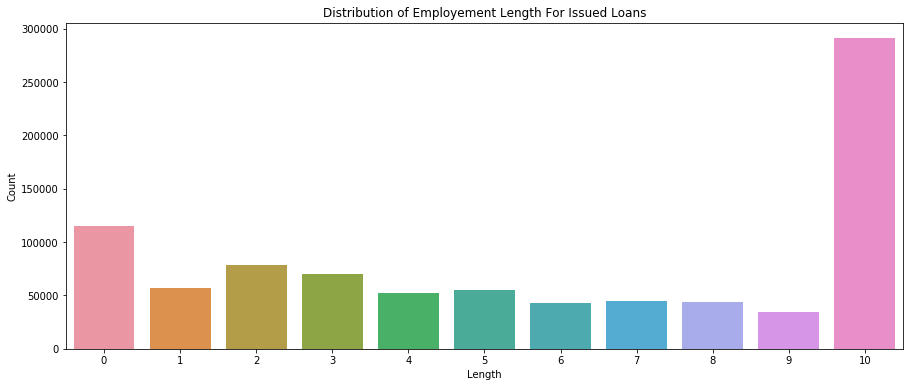

In [11]:
plt.subplots(figsize=(15,6))
sns.barplot(y='count', x='type', data=f)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employement Length For Issued Loans")
plt.show()

### Summary
- People work for **10+ years** have the highest loan issue number(291,569) which is almost three times higher than second place(**0**, 115,430)

### B. Loan Status

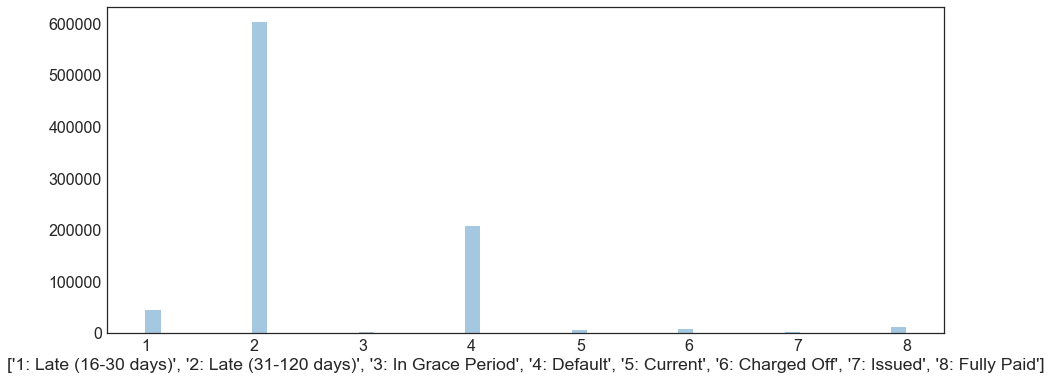

In [15]:
legend = ["1: Late (16-30 days)",
            "2: Late (31-120 days)",
            "3: In Grace Period",
            "4: Default",
            "5: Current",
            "6: Charged Off",
            "7: Issued",
            "8: Fully Paid"]
legend = sorted(legend)
plt.subplots(figsize=(15,6))
sns.set_context("paper", font_scale=2)
sns.set_style("white")
a = sns.distplot(categorize(df_copy["loan_status"]), kde=False)
a.set(xlabel=legend)

plt.legend()
plt.show()

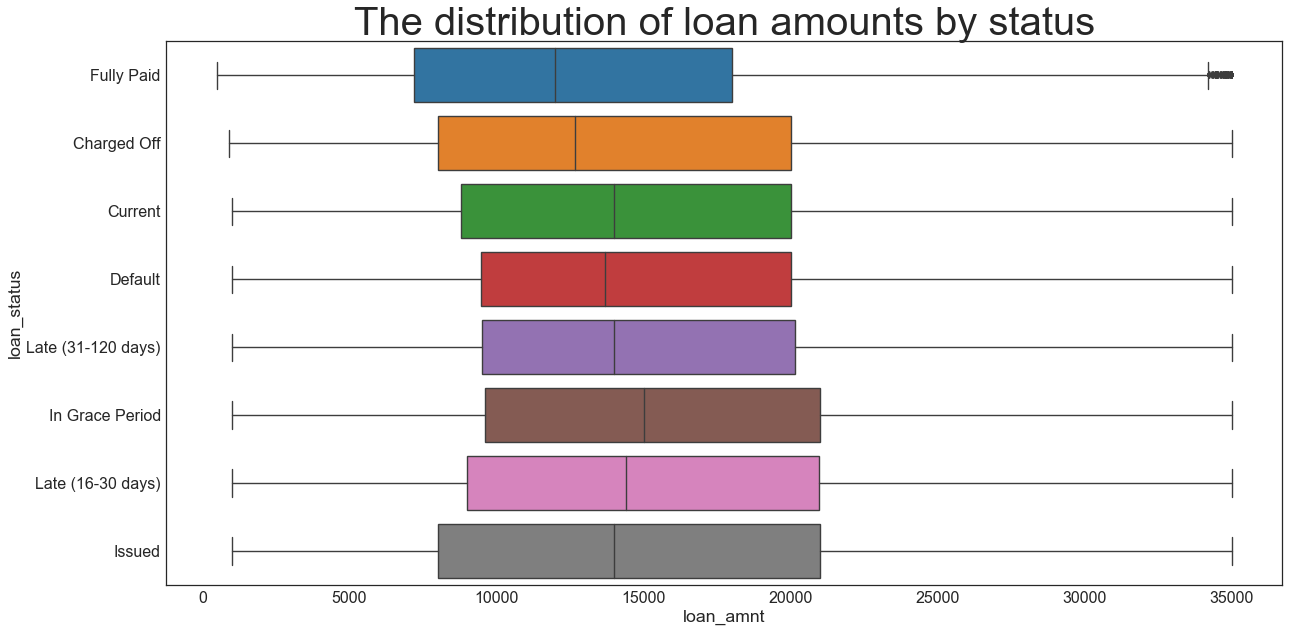

In [16]:
# Loan amount by its status
plt.subplots(figsize=(20,10))
plt.title("The distribution of loan amounts by status").set_size(40)
sns.boxplot(x="loan_amnt", y="loan_status", data=df_copy)

### Summary
- **Default** has the highest count among other **loan status**.
- **In Grace Period** and **Late(16~30 days)** have the highest loan amount and mean.

### C. Loan Amount Base on Grade

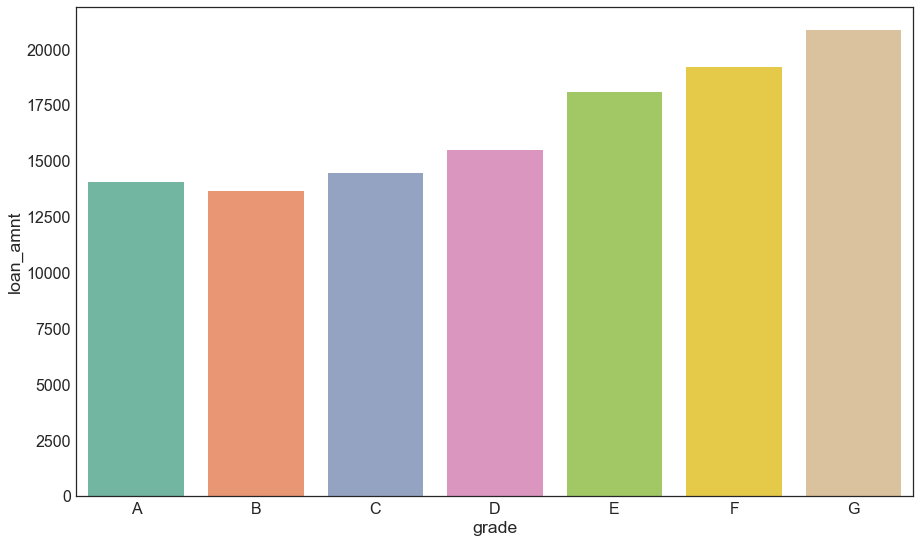

In [17]:
group = df_copy.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2')

### Summary
- The lower grade, the higher loan amount loan issued

In [18]:
# showing columns by name in ascedent order
#df.reindex_axis(sorted(df.columns), axis=1).info()